In [1]:
"""Example showing the optimization and evolution of surrogates"""

# Copyright (c) 2024 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__version__ = "0.4.2"
__deprecated__ = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d(x, y, FX, bounds, label):
    fig, ax = plt.subplots()
    im = ax.imshow(FX, cmap="jet", extent=[bounds[0][0],bounds[0][1],bounds[1][1],bounds[1][0]])
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter(x[0:len(x)-1],y[0:len(x)-1],c='gray',marker='x')
    ax.scatter(x[-1],y[-1],c='w',marker='x')
    return fig, ax

In [3]:
def ackley(x, n: int = 2):
    from math import exp, sqrt, pi

    a = 20
    b = 0.2
    c = 2*pi
    return (
        -a * exp(-b * sqrt(np.dot(x, x) / n))
        - exp(np.sum(np.cos(c * np.asarray(x))) / n)
        + a
        + exp(1)
    )


def eggholder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]+0.5*x[0]+47)))-x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))

objf = {}
# Breaks the symmetry of the problem
objf["ackley"] = lambda x: ackley([xi - 3.14 for xi in x], n=2)
objf["eggholder"] = eggholder

refbounds = {}
refbounds["ackley"] = [-32.768, 32.768]
refbounds["eggholder"] = [-512, 512]

In [4]:
# Define dimensions and bounds
n = 2
funcstr = "eggholder"
bounds = [refbounds[funcstr]] * n

In [5]:
# Compute the mean and standard deviation of the GP
nx = 100
ny = 100
x = np.linspace(bounds[0][0], bounds[0][1], nx)
y = np.linspace(bounds[1][0], bounds[1][1], ny)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

Best value of  -25.460337185286313  at  [0. 0.]
Last samples at  [0. 0.]
Best value of  -173.20081621903958  at  [  81.98072038 -203.53918596]
Last samples at  [  81.98072038 -203.53918596]
Best value of  -272.7488930024395  at  [-258.23198201   12.82765538]
Last samples at  [-258.23198201   12.82765538]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-252.79820007   11.94567669]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-227.26250124    7.80072543]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-239.68463936  -18.31014347]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-222.35611758   23.88875653]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-257.77343465   69.46929885]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [ 119.29767724 -154.07283367

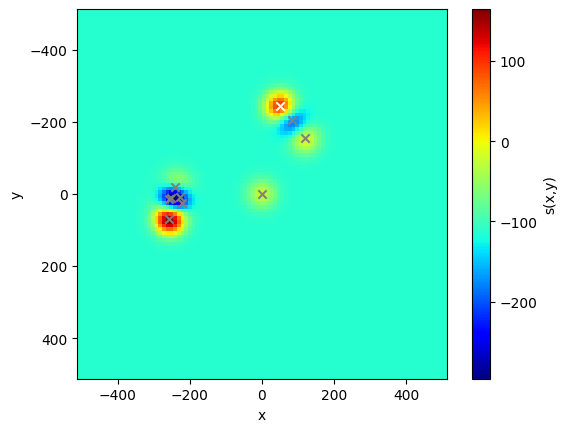

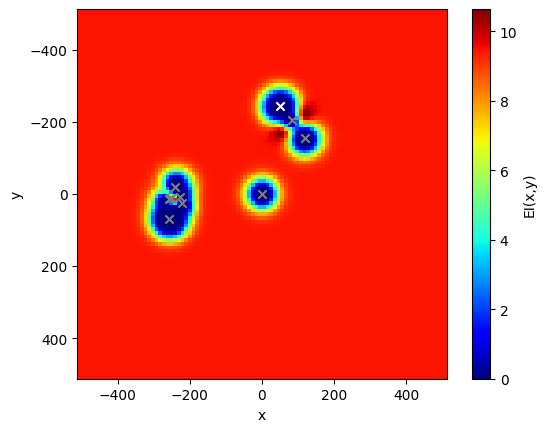

Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [ 127.04332947 -234.04861256]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [  41.97488639 -151.95539864]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-153.84782093   24.54395136]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-470.05901115  253.43229371]
Best value of  -290.1848080934313  at  [-252.79820007   11.94567669]
Last samples at  [-216.24026915 -356.51997426]
Best value of  -295.1990610731843  at  [-241.8966682     8.24600552]
Last samples at  [-241.8966682     8.24600552]
Best value of  -295.1990610731843  at  [-241.8966682     8.24600552]
Last samples at  [ 490.42122911 -396.08288025]
Best value of  -295.1990610731843  at  [-241.8966682     8.24600552]
Last samples at  [-149.50793406  343.90353464]
Best value of  -469.48962515132837  at  [-437.22486175  346.55495056]
La

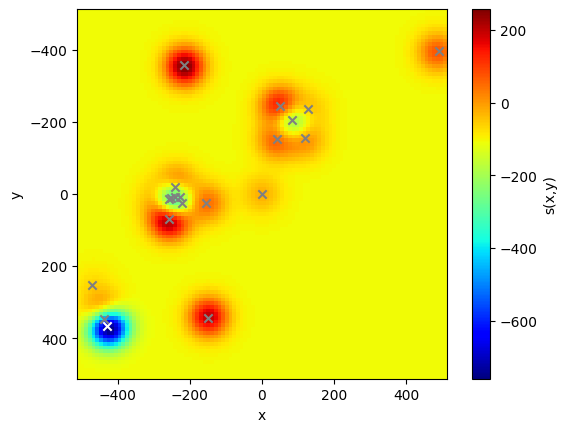

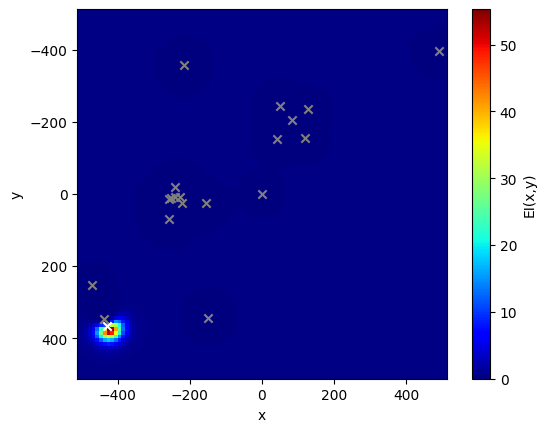

Best value of  -711.578899753229  at  [-425.296327    380.38866975]
Last samples at  [-425.296327    380.38866975]
Best value of  -711.578899753229  at  [-425.296327    380.38866975]
Last samples at  [-413.41644052  368.1004169 ]
Best value of  -822.0521190339078  at  [-440.97102849  377.80958647]
Last samples at  [-440.97102849  377.80958647]
Best value of  -878.8668409710276  at  [-454.22133357  382.48969872]
Last samples at  [-454.22133357  382.48969872]
Best value of  -878.8668409710276  at  [-454.22133357  382.48969872]
Last samples at  [-486.36183931  391.38837798]
Best value of  -878.8668409710276  at  [-454.22133357  382.48969872]
Last samples at  [-464.85332211  401.0868655 ]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-471.18183732  386.28349426]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-504.39398243  155.68379631]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last 

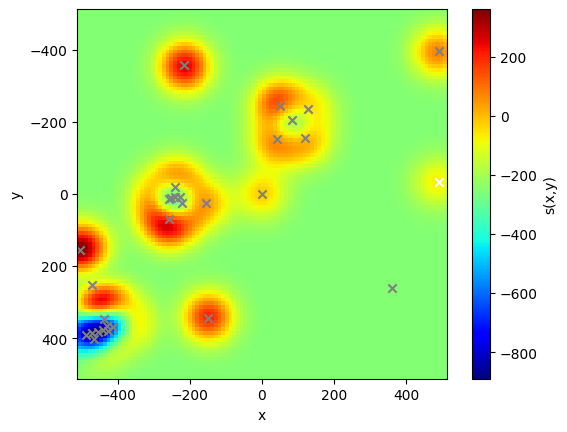

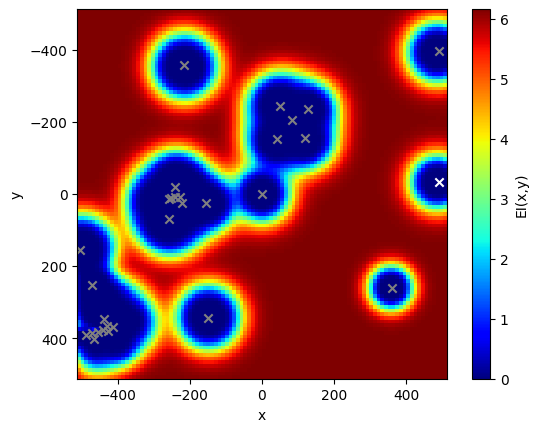

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [160.01363391 506.14769595]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [458.28202744 413.55615188]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [472.53853998 443.83924922]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-421.47554197  386.35517848]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [446.0506899  387.56559825]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [439.76075168 423.98613479]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [470.07378004 396.08505555]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-448.47931294  393.08619262]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at

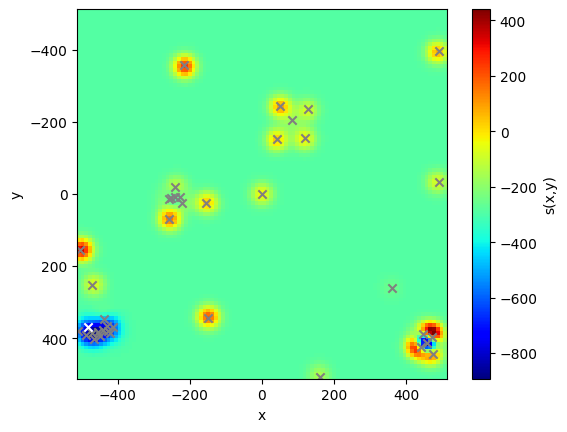

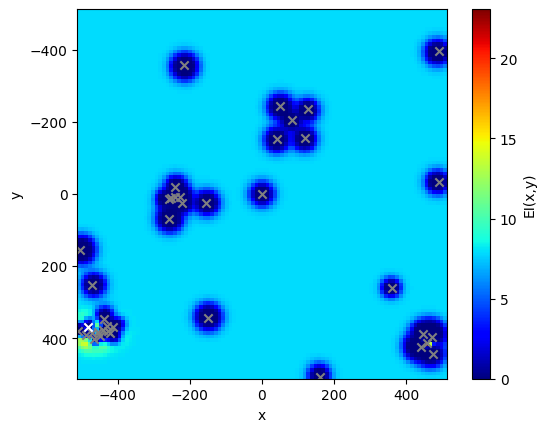

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-447.81185278  425.40160657]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-489.30664944  329.30735523]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-487.70574025  418.07033551]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-374.06560755  401.94460458]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [461.0936935  417.13523768]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-498.35316497  479.38255987]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-317.08274798  270.64094043]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-394.91404644 -246.71159616]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last 

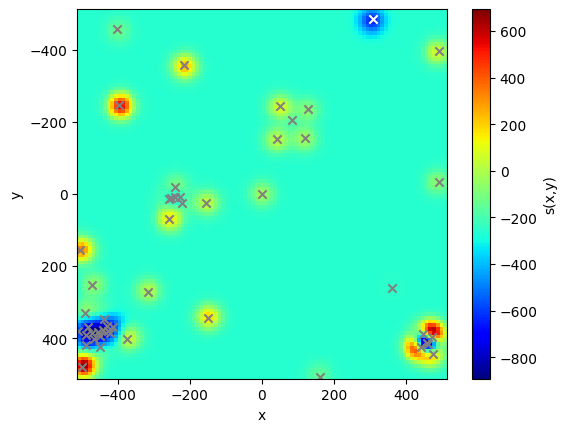

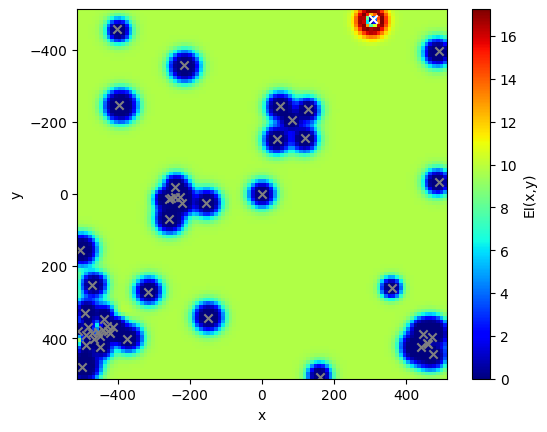

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 335.24858483 -482.91736293]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 303.1168892 -456.1152545]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 277.0673615  -490.54405369]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 282.01755491 -505.73017305]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 246.09397105 -500.54324701]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 252.55856743 -461.93509218]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 239.33351743 -422.02565861]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 205.35454784 -461.80851649]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last 

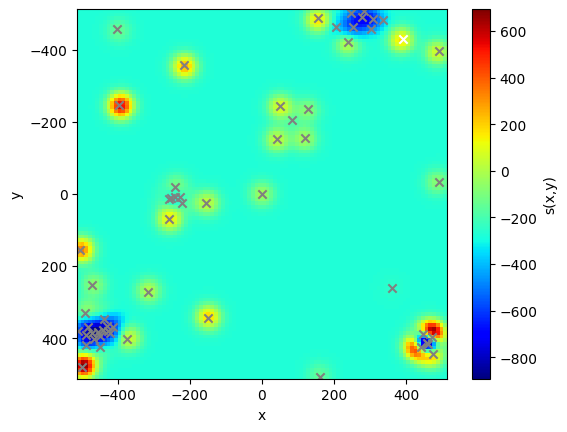

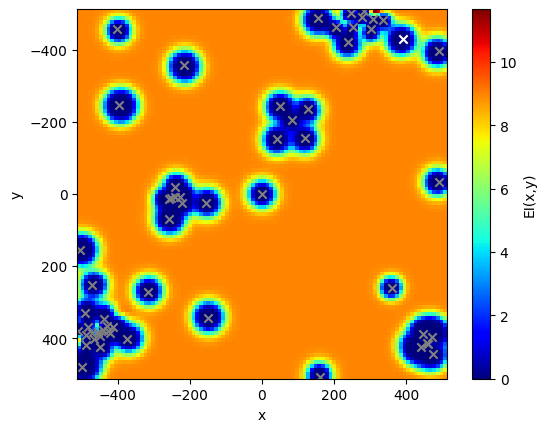

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [181.38080358 102.12736781]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-456.88768717  -43.18440117]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 356.77540746 -204.27141022]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 71.52407178 284.95973901]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ -67.89451366 -511.89846438]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [278.06530239 270.83902731]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 311.95515957 -508.84949936]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-24.87493862 504.62141217]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last sample

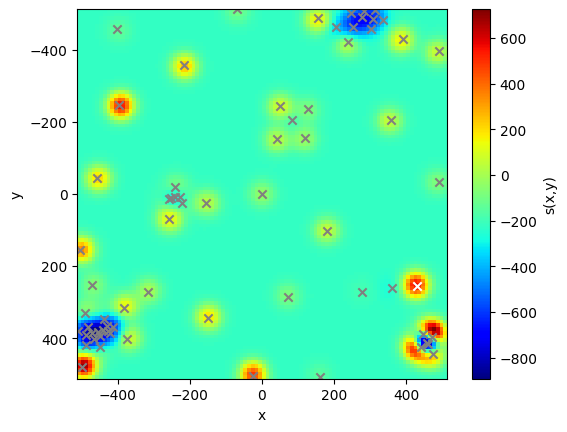

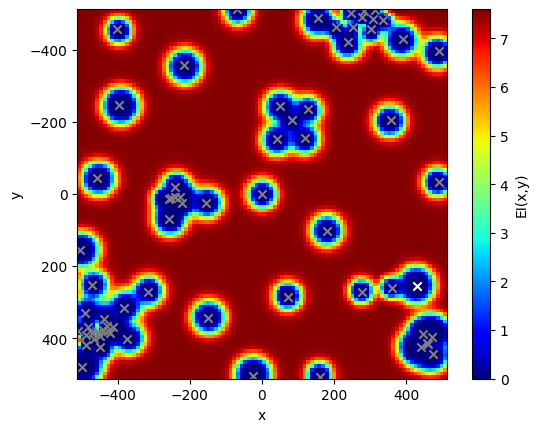

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [330.70555256 331.96451459]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [314.45344061 208.98687066]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [311.56063324 174.30891886]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [319.96627227 238.01285227]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [259.00288247 195.64369248]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [346.14583834 202.68050656]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-149.67516408 -171.46846503]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [198.52861723 282.35396441]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  

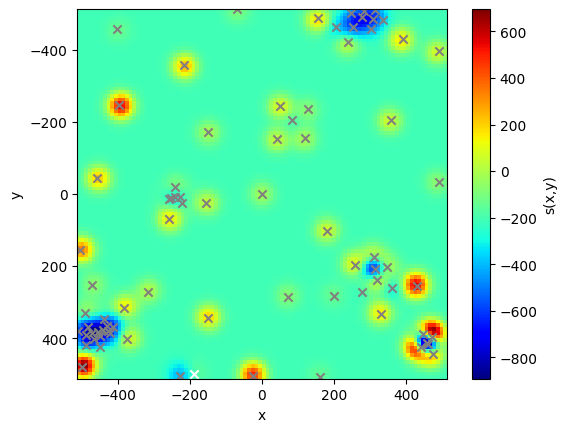

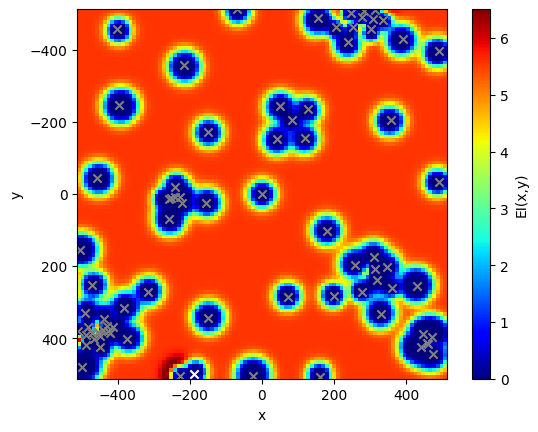

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-269.59565713  485.55811924]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-239.88703006  465.60308085]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-311.17408245  501.43138154]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-326.41105336  479.23472087]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [310.94901837 -21.92994444]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-289.883034  512.      ]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-62.87978739 157.40325376]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-300.80069179  488.54456868]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last sample

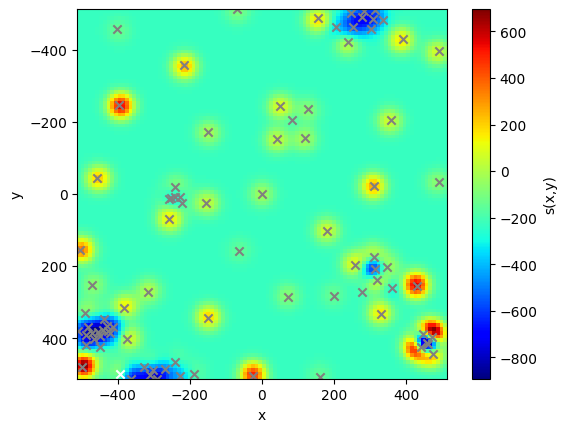

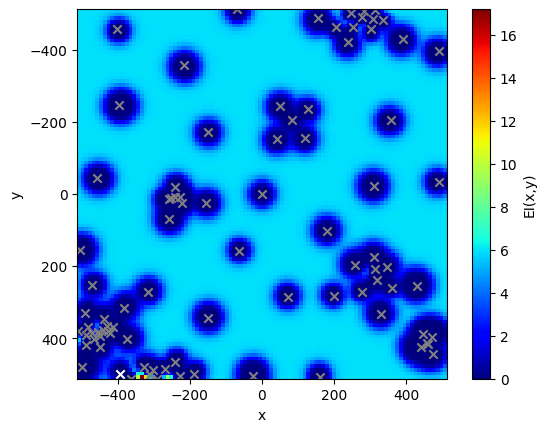

Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [  29.80402491 -400.50938155]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-239.60344995 -508.678381  ]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 503.25013895 -188.72526137]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [-261.18297737  510.26477875]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 478.78680326 -262.36249742]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 459.0099691  -242.79338324]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 499.0356631  -280.90506883]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Last samples at  [ 471.23261311 -288.63326081]
Best value of  -890.8644489275122  at  [-471.18183732  386.28349426]
Las

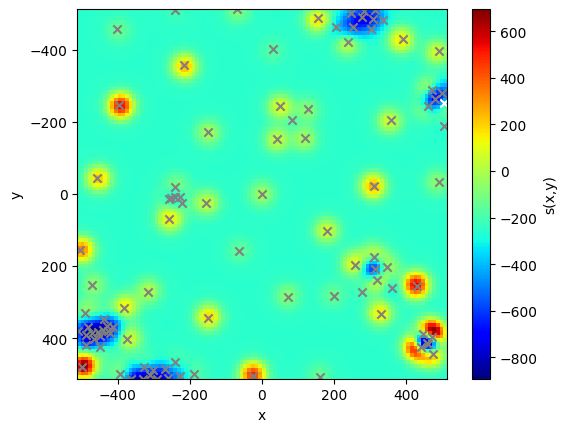

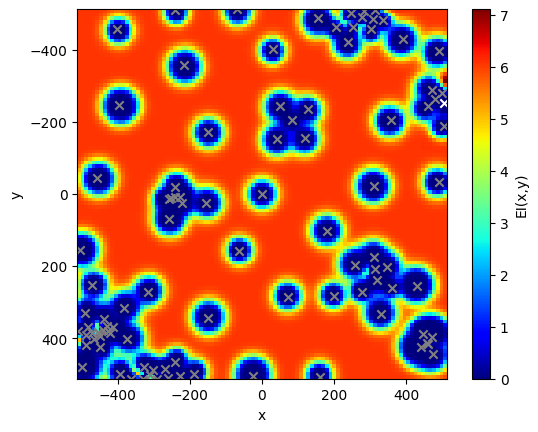

OptimizeResult(x=array([-471.18183732,  386.28349426]), fx=-890.8644489275122, nit=99, nfev=100, samples=array([[   0.        ,    0.        ],
       [  81.98072038, -203.53918596],
       [-258.23198201,   12.82765538],
       [-252.79820007,   11.94567669],
       [-227.26250124,    7.80072543],
       [-239.68463936,  -18.31014347],
       [-222.35611758,   23.88875653],
       [-257.77343465,   69.46929885],
       [ 119.29767724, -154.07283367],
       [  51.27407524, -243.82298161],
       [ 127.04332947, -234.04861256],
       [  41.97488639, -151.95539864],
       [-153.84782093,   24.54395136],
       [-470.05901115,  253.43229371],
       [-216.24026915, -356.51997426],
       [-241.8966682 ,    8.24600552],
       [ 490.42122911, -396.08288025],
       [-149.50793406,  343.90353464],
       [-437.22486175,  346.55495056],
       [-430.58893273,  365.37691922],
       [-425.296327  ,  380.38866975],
       [-413.41644052,  368.1004169 ],
       [-440.97102849,  377.80958647]

In [6]:
from blackboxopt.optimize import bayesian_optimization, cptv, OptimizeResult, multistart_stochastic_response_surface, target_value_optimization
from blackboxopt.gp import GaussianProcess, expected_improvement
from blackboxopt.rbf import RbfModel
from sklearn.gaussian_process.kernels import RBF as GPkernelRBF

def callback_rbf(out: OptimizeResult):
    model = RbfModel()
    model.reserve(0, n)
    model.update_samples(out.samples[0:out.nfev,:])
    model.update_coefficients(out.fsamples[0:out.nfev])

    S = np.zeros((ny,nx))
    for i in range(ny):
        S[i, :], _ = model(XY[i, :])

    print("Best value of ", out.fx, " at ", out.x)
    print("Last samples at ", out.samples[out.nfev-1])

    plot_2d(out.samples[0:out.nfev,0], out.samples[0:out.nfev,1], S, bounds, "s(x,y)")
    plt.savefig("surrogate_{:03d}.png".format(out.nfev))
    if out.nfev % 10 == 0:
        plt.show()
    else:
        plt.close()

def callback_gp(out: OptimizeResult):
    model = GaussianProcess(GPkernelRBF(), n_restarts_optimizer=20, normalize_y=True)
    model.fit(out.samples[0:out.nfev,:], out.fsamples[0:out.nfev])

    Mean = np.zeros((ny,nx))
    Std = np.zeros((ny,nx))
    EI = np.zeros((ny,nx))
    for i in range(ny):
        Mean[i, :], Std[i, :] = model(XY[i, :])
        EI[i, :] = expected_improvement(Mean[i, :], Std[i, :], out.fx)

    print("Best value of ", out.fx, " at ", out.x)
    print("Last samples at ", out.samples[out.nfev-1])

    plot_2d(out.samples[0:out.nfev,0], out.samples[0:out.nfev,1], Mean, bounds, "s(x,y)")
    plt.savefig("surrogate_{:03d}.png".format(out.nfev))
    if out.nfev % 10 == 0:
        plt.show()
    else:
        plt.close()

    plot_2d(out.samples[0:out.nfev,0], out.samples[0:out.nfev,1], EI, bounds, "EI(x,y)")
    plt.savefig("EI_{:03d}.png".format(out.nfev))
    if out.nfev % 10 == 0:
        plt.show()
    else:
        plt.close()

np.random.seed(3)
bayesian_optimization(lambda x: [objf[funcstr](x[0])], bounds=bounds, maxeval=100, callback=callback_gp)
# cptv(lambda x: [objf[funcstr](x[0])], bounds=bounds, maxeval=100, callback=callback_rbf)
# target_value_optimization(lambda x: [objf[funcstr](x[0])], bounds=bounds, maxeval=100, callback=callback_rbf)
# multistart_stochastic_response_surface(lambda x: [objf[funcstr](x[0])], bounds=bounds, maxeval=100, callback=callback_rbf)